In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon

In [31]:
class Cube(object):
    """
    Cube
    ----
    Initialize with arguments:
    - `N`, the side length (the cube is `N`x`N`x`N`)
    - optional `whiteplastic=True` if you like white cubes
    """
    facedict = {"U":0, "D":1, "F":2, "B":3, "R":4, "L":5}
    dictface = dict([(v, k) for k, v in facedict.items()])
    normals = [np.array([0., 1., 0.]), np.array([0., -1., 0.]),
               np.array([0., 0., 1.]), np.array([0., 0., -1.]),
               np.array([1., 0., 0.]), np.array([-1., 0., 0.])]
    # this xdirs has to be synchronized with the self.move() function
    xdirs = [np.array([1., 0., 0.]), np.array([1., 0., 0.]),
               np.array([1., 0., 0.]), np.array([-1., 0., 0.]),
               np.array([0., 0., -1.]), np.array([0, 0., 1.])]
    colordict = {"w":0, "y":1, "b":2, "g":3, "o":4, "r":5}
    pltpos = [(0., 1.05), (0., -1.05), (0., 0.), (2.10, 0.), (1.05, 0.), (-1.05, 0.)]
    labelcolor = "#7f00ff"

    def __init__(self, N, whiteplastic=False):
        """
        (see above)
        """
        self.N = N
        self.stickers = np.array([np.tile(i, (self.N, self.N)) for i in range(6)])
        self.stickercolors = ["w", "#ffcf00", "#00008f", "#009f0f", "#ff6f00", "#cf0000"]
        self.stickerthickness = 0.001 # sticker thickness in units of total cube size
        self.stickerwidth = 0.9 # sticker size relative to cubie size (must be < 1)
        if whiteplastic:
            self.plasticcolor = "#dfdfdf"
        else:
            self.plasticcolor = "#1f1f1f"
        self.fontsize = 12. * (self.N / 5.)
        return None

    def turn(self, f, d):
        """
        Turn whole cube (without making a layer move) around face `f`
        `d` 90-degree turns in the clockwise direction.  Use `d=3` or
        `d=-1` for counter-clockwise.
        """
        for l in range(self.N):
            self.move(f, l, d)
        return None

    def move(self, f, l, d):
        """
        Make a layer move of layer `l` parallel to face `f` through
        `d` 90-degree turns in the clockwise direction.  Layer `0` is
        the face itself, and higher `l` values are for layers deeper
        into the cube.  Use `d=3` or `d=-1` for counter-clockwise
        moves, and `d=2` for a 180-degree move..
        """
        i = self.facedict[f]
        l2 = self.N - 1 - l
        assert l < self.N
        ds = range((d + 4) % 4)
        if f == "U":
            f2 = "D"
            i2 = self.facedict[f2]
            for d in ds:
                self._rotate([(self.facedict["F"], range(self.N), l2),
                              (self.facedict["R"], range(self.N), l2),
                              (self.facedict["B"], range(self.N), l2),
                              (self.facedict["L"], range(self.N), l2)])
        if f == "D":
            return self.move("U", l2, -d)
        if f == "F":
            f2 = "B"
            i2 = self.facedict[f2]
            for d in ds:
                self._rotate([(self.facedict["U"], range(self.N), l),
                              (self.facedict["L"], l2, range(self.N)),
                              (self.facedict["D"], range(self.N)[::-1], l2),
                              (self.facedict["R"], l, range(self.N)[::-1])])
        if f == "B":
            return self.move("F", l2, -d)
        if f == "R":
            f2 = "L"
            i2 = self.facedict[f2]
            for d in ds:
                self._rotate([(self.facedict["U"], l2, range(self.N)),
                              (self.facedict["F"], l2, range(self.N)),
                              (self.facedict["D"], l2, range(self.N)),
                              (self.facedict["B"], l, range(self.N)[::-1])])
        if f == "L":
            return self.move("R", l2, -d)
        for d in ds:
            if l == 0:
                self.stickers[i] = np.rot90(self.stickers[i], 3)
            if l == self.N - 1:
                self.stickers[i2] = np.rot90(self.stickers[i2], 1)
        #print("moved", f, l, len(ds))
        return None

    def _rotate(self, args):
        """
        Internal function for the `move()` function.
        """
        a0 = args[0]
        foo = self.stickers[a0]
        a = a0
        for b in args[1:]:
            self.stickers[a] = self.stickers[b]
            a = b
        self.stickers[a] = foo
        return None

    def randomize(self, number):
        """
        Make `number` randomly chosen moves to scramble the cube.
        """
        for t in range(number):
            f = self.dictface[np.random.randint(6)]
            l = np.random.randint(self.N)
            d = 1 + np.random.randint(3)
            self.move(f, l, d)
        return None

    def _render_points(self, points, viewpoint):
        """
        Internal function for the `render()` function.  Clunky
        projection from 3-d to 2-d, but also return a zorder variable.
        """
        v2 = np.dot(viewpoint, viewpoint)
        zdir = viewpoint / np.sqrt(v2)
        xdir = np.cross(np.array([0., 1., 0.]), zdir)
        xdir /= np.sqrt(np.dot(xdir, xdir))
        ydir = np.cross(zdir, xdir)
        result = []
        for p in points:
            dpoint = p - viewpoint
            dproj = 0.5 * dpoint * v2 / np.dot(dpoint, -1. * viewpoint)
            result += [np.array([np.dot(xdir, dproj),
                                 np.dot(ydir, dproj),
                                 np.dot(zdir, dpoint / np.sqrt(v2))])]
        return result

    def render_views(self, ax):
        """
        Make three projected 3-dimensional views of the cube for the
        `render()` function.  Because of zorder / occulting issues,
        this code is very brittle; it will not work for all viewpoints
        (the `np.dot(zdir, viewpoint)` test is not general; the corect
        test involves the "handedness" of the projected polygon).
        """
        csz = 2. / self.N
        x2 = 8.
        x1 = 0.5 * x2
        for viewpoint, shift in [(np.array([-x1, -x1, x2]), np.array([-1.5, 3.])),
                                 (np.array([x1, x1, x2]), np.array([0.5, 3.])),
                                 (np.array([x2, x1, -x1]), np.array([2.5, 3.]))]:
            for f, i in self.facedict.items():
                zdir = self.normals[i]
                if np.dot(zdir, viewpoint) < 0:
                    continue
                xdir = self.xdirs[i]
                ydir = np.cross(zdir, xdir) # insanity: left-handed!
                psc = 1. - 2. * self.stickerthickness
                corners = [psc * zdir - psc * xdir - psc * ydir,
                           psc * zdir + psc * xdir - psc * ydir,
                           psc * zdir + psc * xdir + psc * ydir,
                           psc * zdir - psc * xdir + psc * ydir]
                projects = self._render_points(corners, viewpoint)
                xys = [p[0:2] + shift for p in projects]
                zorder = np.mean([p[2] for p in projects])
                ax.add_artist(Polygon(xys, ec="none", fc=self.plasticcolor))
                for j in range(self.N):
                    for k in range(self.N):
                        corners = self._stickerpolygon(xdir, ydir, zdir, csz, j, k)
                        projects = self._render_points(corners, viewpoint)
                        xys = [p[0:2] + shift for p in projects]
                        ax.add_artist(Polygon(xys, ec="none", fc=self.stickercolors[self.stickers[i, j, k]]))
                x0, y0, zorder = self._render_points([1.5 * self.normals[i], ], viewpoint)[0]
                ax.text(x0 + shift[0], y0 + shift[1], f, color=self.labelcolor,
                        ha="center", va="center", rotation=20, fontsize=self.fontsize / (-zorder))
        return None

    def _stickerpolygon(self, xdir, ydir, zdir, csz, j, k):
        small = 0.5 * (1. - self.stickerwidth)
        large = 1. - small
        return [zdir - xdir + (j + small) * csz * xdir - ydir + (k + small + small) * csz * ydir,
                zdir - xdir + (j + small + small) * csz * xdir - ydir + (k + small) * csz * ydir,
                zdir - xdir + (j + large - small) * csz * xdir - ydir + (k + small) * csz * ydir,
                zdir - xdir + (j + large) * csz * xdir - ydir + (k + small + small) * csz * ydir,
                zdir - xdir + (j + large) * csz * xdir - ydir + (k + large - small) * csz * ydir,
                zdir - xdir + (j + large - small) * csz * xdir - ydir + (k + large) * csz * ydir,
                zdir - xdir + (j + small + small) * csz * xdir - ydir + (k + large) * csz * ydir,
                zdir - xdir + (j + small) * csz * xdir - ydir + (k + large - small) * csz * ydir]

    def render_flat(self, ax):
        """
        Make an unwrapped, flat view of the cube for the `render()`
        function.  This is a map, not a view really.  It does not
        properly render the plastic and stickers.
        """
        for f, i in self.facedict.items():
            x0, y0 = self.pltpos[i]
            cs = 1. / self.N
            for j in range(self.N):
                for k in range(self.N):
                    ax.add_artist(Rectangle((x0 + j * cs, y0 + k * cs), cs, cs, ec=self.plasticcolor,
                                            fc=self.stickercolors[self.stickers[i, j, k]]))
            ax.text(x0 + 0.5, y0 + 0.5, f, color=self.labelcolor,
                    ha="center", va="center", rotation=20, fontsize=self.fontsize)
        return None

    def render(self, flat=True, views=True):
        """
        Visualize the cube in a standard layout, including a flat,
        unwrapped view and three perspective views.
        """
        assert flat or views
        xlim = (-2.4, 3.4)
        ylim = (-1.2, 4.)
        if not flat:
            ylim = (2., 4.)
        if not views:
            xlim = (-1.2, 3.2)
            ylim = (-1.2, 2.2)
        fig = plt.figure(figsize=((xlim[1] - xlim[0]) * self.N / 5., (ylim[1] - ylim[0]) * self.N / 5.))
        ax = fig.add_axes((0, 0, 1, 1), frameon=False,
                          xticks=[], yticks=[])
        if views:
            self.render_views(ax)
        if flat:
            self.render_flat(ax)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        return fig
    def isSolved(self) :
        #Creates a compariable array that represents the cube
        x = self.stickers
        y = Cube(self.N).stickers
        if (np.array_equal(x,y)):
            #print("Is Solved")
            equality = True
        else:
            #print("Not Solved")
            equality = False
        return equality


In [32]:
def adjacent_edge_flip(cube):
    """
    Do a standard edge-flipping algorithm.  Used for testing.
    """
    ls = range(cube.N)[1:-1]
    cube.move("R", 0, -1)
    for l in ls:
        cube.move("U", l, 1)
    cube.move("R", 0, 2)
    for l in ls:
        cube.move("U", l, 2)
    cube.move("R", 0, -1)
    cube.move("U", 0, -1)
    cube.move("R", 0, 1)
    for l in ls:
        cube.move("U", l, 2)
    cube.move("R", 0, 2)
    for l in ls:
        cube.move("U", l, -1)
    cube.move("R", 0, 1)
    cube.move("U", 0, 1)
    return None

def swap_off_diagonal(cube, f, l1, l2):
    """
    A big-cube move that swaps three cubies (I think) but looks like two.
    """
    cube.move(f, l1, 1)
    cube.move(f, l2, 1)
    cube.move("U", 0, -1)
    cube.move(f, l2, -1)
    cube.move("U", 0, 1)
    cube.move(f, l1, -1)
    cube.move("U", 0, -1)
    cube.move(f, l2, 1)
    cube.move("U", 0, 1)
    cube.move(f, l2, -1)
    return None

def checkerboard(cube):
    """
    Dumbness.
    """
    ls = range(cube.N)[::2]
    for f in ["U", "F", "R"]:
        for l in ls:
            cube.move(f, l, 2)
    if cube.N % 2 == 0:
        for l in ls:
            cube.move("F", l, 2)
    return None


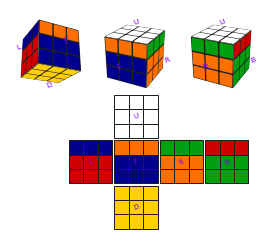

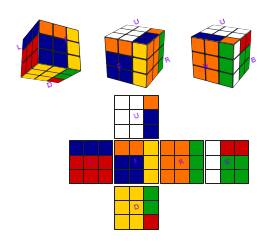

In [33]:
####################################################################################################
# This Cell is an exaple of how to create cube objects and how to call permutations of the cube
####################################################################################################


####################################################################################################
# This creates two cubes. c is a 7X7X7 and s is a 3X3X3
####################################################################################################
c = Cube(7)
s = Cube(3)

####################################################################################################
# This will apply a checkerboard pattern to the cube object c. Then It will check to see if it is 
# solved. Should be false since it is not solved
####################################################################################################
#checkerboard(c);
#c.render()
#c.isSolved()

####################################################################################################
# This will apply a checkerboard pattern to the cube object c. Then It will check to see if it is 
# solved. Should be True since the checkerboard algorithim has order 2
####################################################################################################
#checkerboard(c);
#c.isSolved()

####################################################################################################
# This is how we display the state of the cube
####################################################################################################
#fig = c.render()
    # c.render(flat = True, views = True )
    
####################################################################################################
# This is how we display the state of the cube and save to a png file
####################################################################################################
#s.render(flat=False).savefig("figures/test%02d.png" % 1, dpi=865 / c.N)


####################################################################################################
# This applies K random moves. In this example K = 5
####################################################################################################
#c.randomize(5)
#fig = c.render()

####################################################################################################
# This is some more exaples of calling specfic permutaions based of U D L R F B notation
####################################################################################################
#s.turn("U", 1)

s.move("U", 0, 1)
fig = s.render()
#s.render()
#swap_off_diagonal(c, "R", 2, 1)
s.move("R",0, 1)
fig = s.render()
#swap_off_diagonal(c, "R", 3, 2)
#checkerboard(c)


In [35]:
#################################################################################################
# This Cell calculates the order of a sequence of moves (i.e. algorithim)  
#################################################################################################

c3 = Cube(3)

print(c3.isSolved())
solved = False
count = 0
while not solved :
    c3.move("U", 0, 1)
    c3.move("R", 0, 1)
    #c3.move("L", 0, 1)
    count = count + 1
    solved = c3.isSolved();
    if count%10 == 5:
        print(count)
print("Final Count : ",count)

True
5
15
25
35
45
55
65
75
85
95
105
Final Count :  105
